<a href="https://colab.research.google.com/github/carmenscar/Data-Science-projects/blob/master/RNN_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autor: Carmen Scartezini



# Multi-variate Time series with Deep Learning

<p align=center>
<img src="
https://img.freepik.com/free-photo/clock-time-reminder-alarm-countdown-graphic_53876-128050.jpg?w=1480&t=st=1698430108~exp=1698430708~hmac=50477209618f58d99a5a8cfe7693772f21498d323359a44ebf70464fbdda0b54" width="60%"></p>

In this notebook, we conducted an analysis of vanilla Deep Learning models, which refers to the implementation of fundamental, baseline models without significant modifications or complex enhancements, for time series data.

The primary approach involves the implementation and comparison of three fundamental vanilla models: Recurrent Neural Networks (**RNN**), Long Short-Term Memory (**LSTM**), and a combination of LSTM and Convolutional Neural Networks (**LSTM-CNN**).

Vanilla models represent a basic, unmodified version of the respective architectures, serving as the initial building blocks for developing more sophisticated and customized solutions in the field of Deep Learning. Our objective is to evaluate and comprehend the changes in predictions generated by each vanilla model on different time series datasets.

###Analysis of Prediction Changes
During the implementation and analysis of the vanilla models, we will closely observe the changes in predictions for each model. This includes evaluating predictive performance on various time series datasets, comparing relevant evaluation metrics, and analyzing how the specific features of each vanilla model influence the final predictions. By comparing the predictions, we aim to grasp the relative effectiveness of each vanilla model and determine their recommended use cases in specific time series contexts.

##Imports

In [ ]:
!pip install kaggle
import zipfile
from IPython.display import FileLink
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def df_windowning(df, window_size):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = [r for r in df[i:i+window_size]]
    X.append(row)
    label = df[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

def plot_real_predict(model,x_test, y_test):
  y_pred_test = model.predict(x_test)
  plt.figure(figsize=(10, 6))
  plt.plot(y_test, label='Real (Test)')
  plt.plot(y_pred_test, label='Predicted (Test)')
  plt.title('Predicted and Real Values (Test)')
  plt.legend()
  plt.show()

def plot_mape(history_model):
  plt.plot(history_model.history['mean_absolute_percentage_error'])
  plt.plot(history_model.history['val_mean_absolute_percentage_error'])
  plt.title('Model MAPE')
  plt.ylabel('MAPE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

##Dataset and Data Connection
We will utilize a dataset from Kaggle for the application of these models. The dataset will serve as the foundation for training and testing the various time series models. We have established a data connection through the Kaggle API, enabling seamless access to the necessary datasets for the analysis and implementation of the models.

##File Descriptions:

**train.csv**

* `id`: Sale ID,
* `date`: Date of the sale,
* `store_nbr`: Store ID where the product was sold,
* `family`: Type of product sold,
* `sales`: Total sales in $,
* `onpromotion`: Total number of items from a product family that were on promotion.

There is other files that we can merge to get more information but lets keep it simple

In [ ]:
# Define path, change permissions (to get token go to 'create new token' in your kaggle profile)
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# the API address for dataset download
!kaggle competitions download -c store-sales-time-series-forecasting

 65% 14.0M/21.4M [00:00<00:00, 146MB/s]
100% 21.4M/21.4M [00:00<00:00, 179MB/s]


In [ ]:
# Path to google colab enviroment
zip_path = "/content/store-sales-time-series-forecasting.zip"

# Open ZIP and take a sneakpic
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_files = zip_ref.namelist()
    for file in zip_files:
        print(file)

holidays_events.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv


In [ ]:
#Create dataframe
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extract("train.csv", path="/content")

df = pd.read_csv('/content/train.csv')

##Data Wrangling

**Deletion of Features**:

In order to keep the model simple for testing purposes, certain features were deleted from the dataset. This was done to reduce the complexity of the model, allowing for a more straightforward analysis and initial testing of the model's performance.



In [ ]:
#sneak peek on data
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
df.drop(['id', 'store_nbr','onpromotion' ], axis=1, inplace=True)

In [ ]:
df_agg = df.groupby(['date','family']).agg({'sales': 'sum'}).reset_index()

In [ ]:
df_agg.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,2.0
3,2013-01-01,BEVERAGES,810.0
4,2013-01-01,BOOKS,0.0


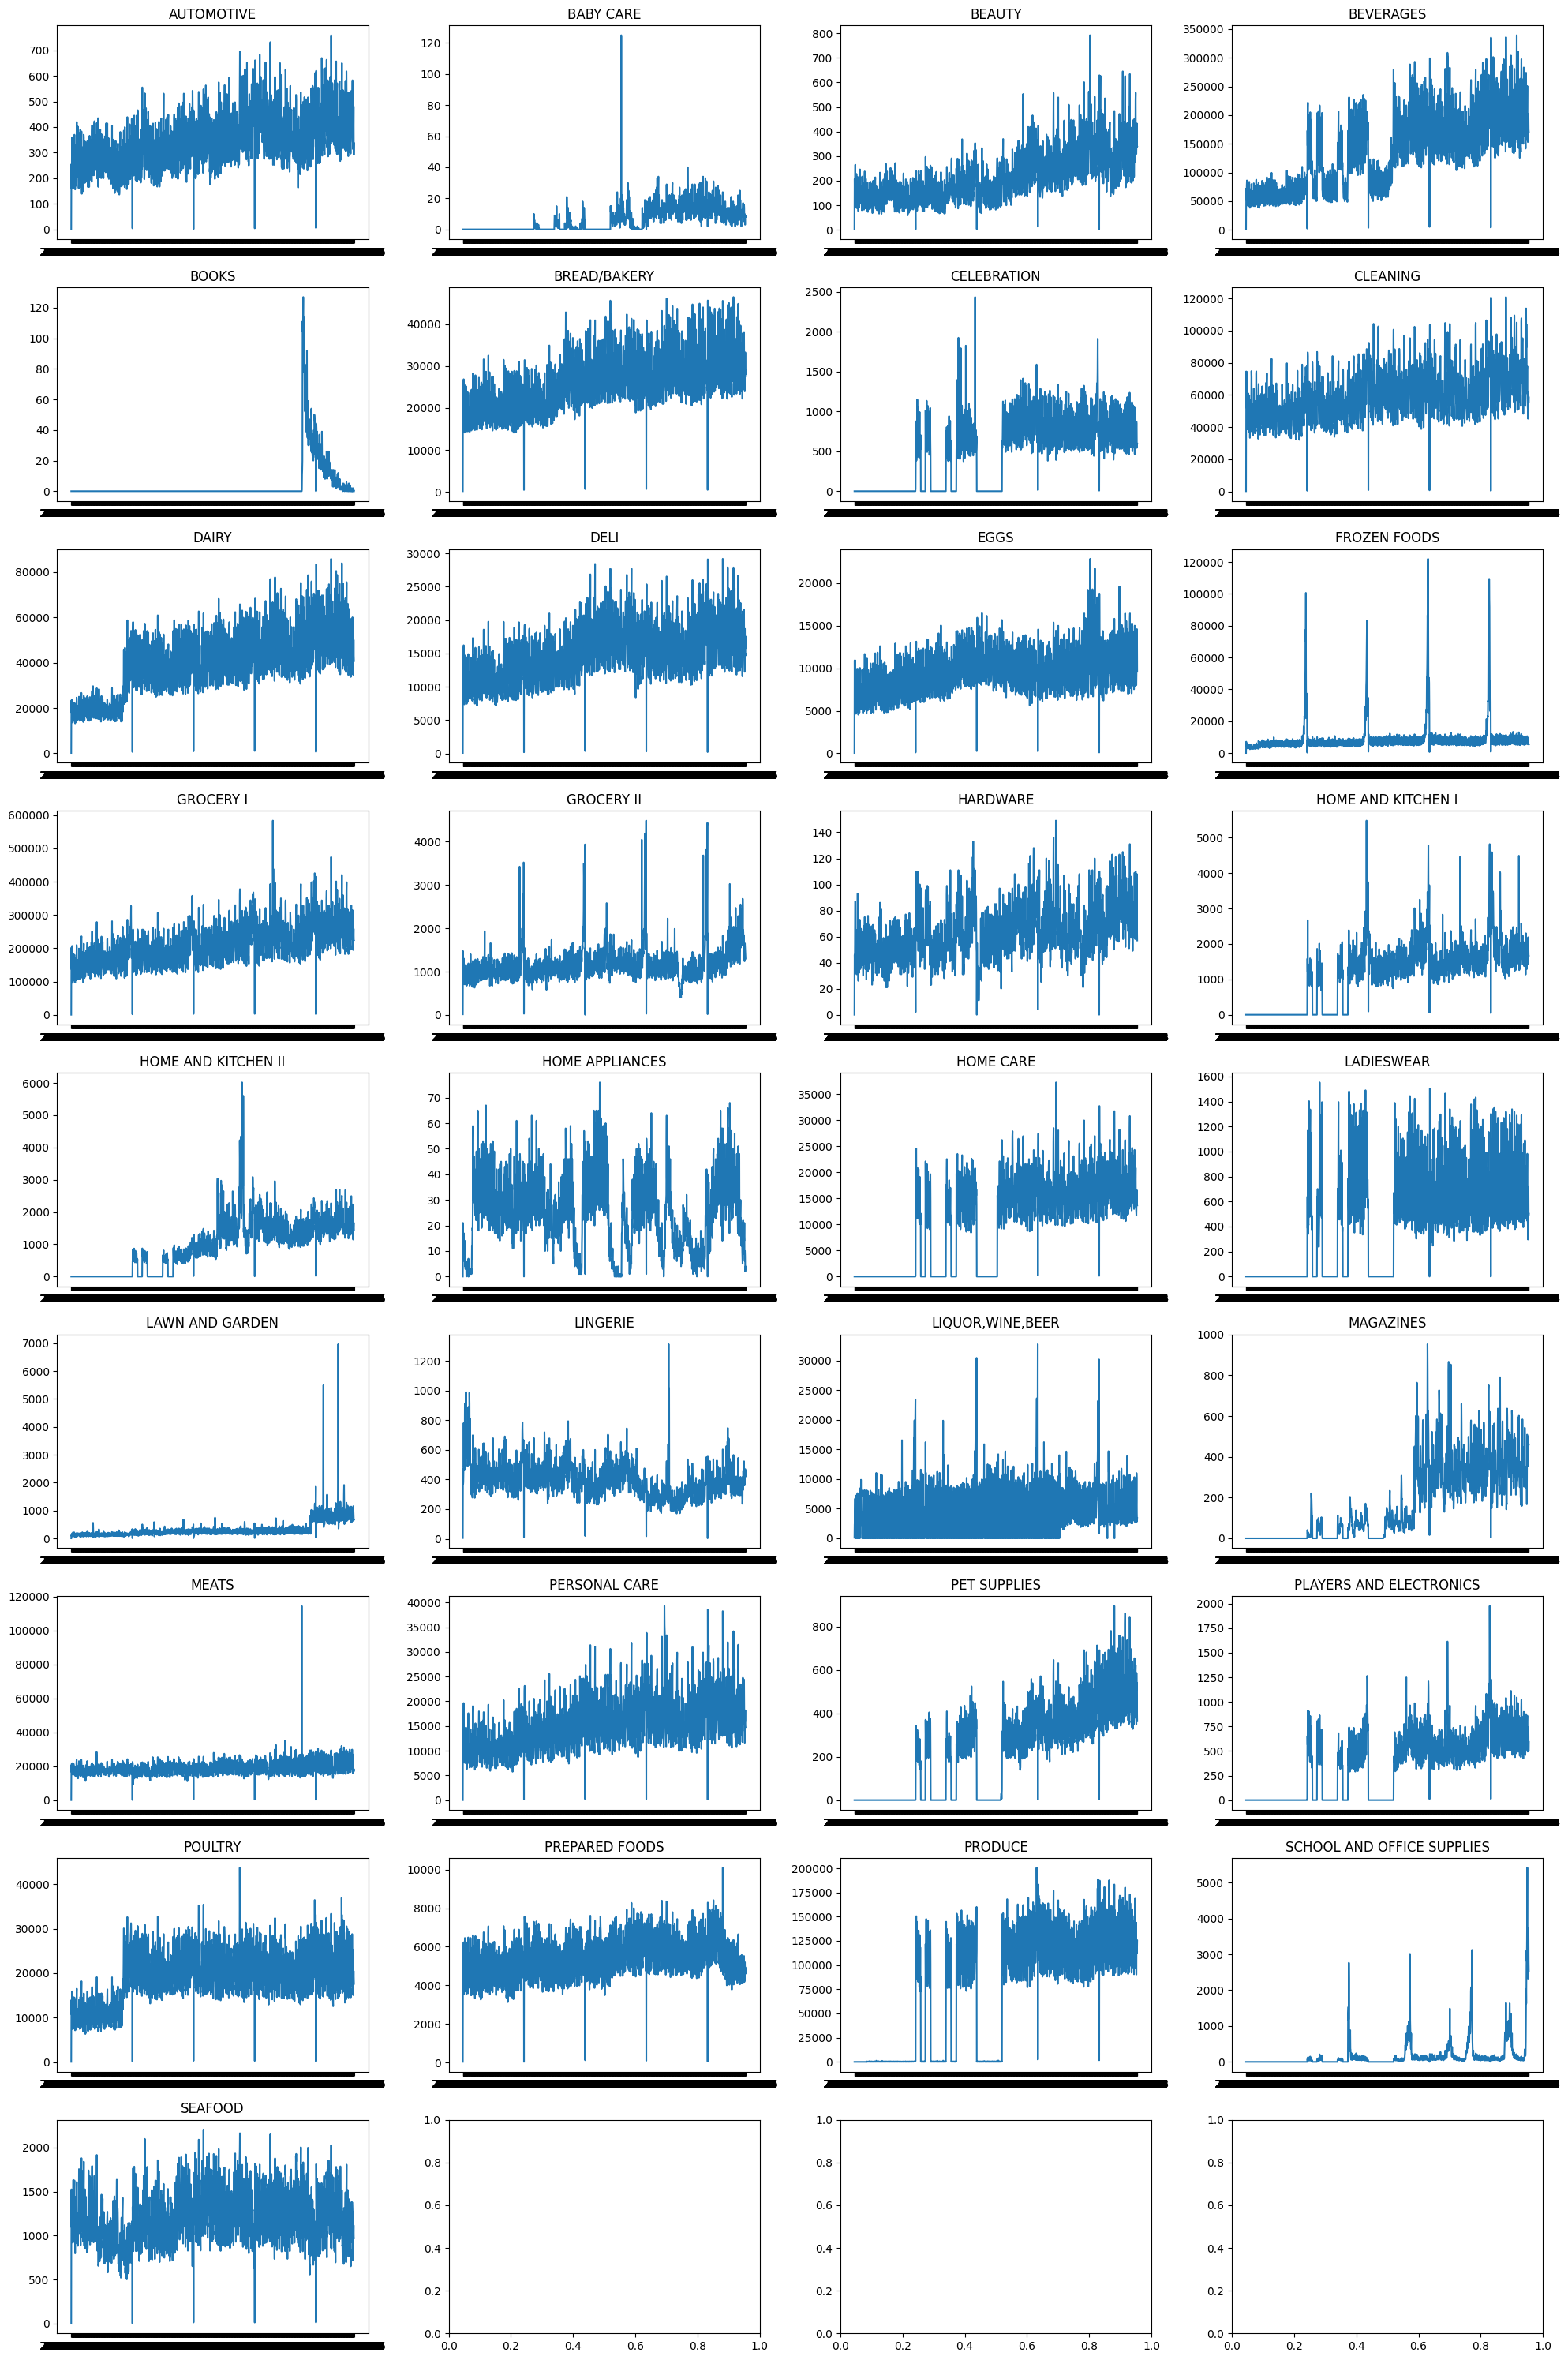

In [ ]:
# Group by category and collect data
categories = df_agg['family'].unique()

# Set up the number of subplots
num_rows = 9
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 30))

# Iterate over each category
for i, category in enumerate(categories):
    df_filtered = df_agg[df_agg['family'] == category]
    x = df_filtered['date'].tolist()
    y = df_filtered['sales'].tolist()

    # Plot the graph
    ax = axs[i // num_cols, i % num_cols]
    ax.plot(x, y)
    ax.set_title(category)

# Adjust the layout of the subplots and display the graphs
plt.tight_layout()
plt.show()


#### We choose 'FROZEN FOODS' to analise because its the family of products that has a a wery distinct pattern as we can see above

In [ ]:
# Filtering the DataFrame based on the 'family' column
df_agg_FF = df_agg[df_agg['family'] == 'FROZEN FOODS']

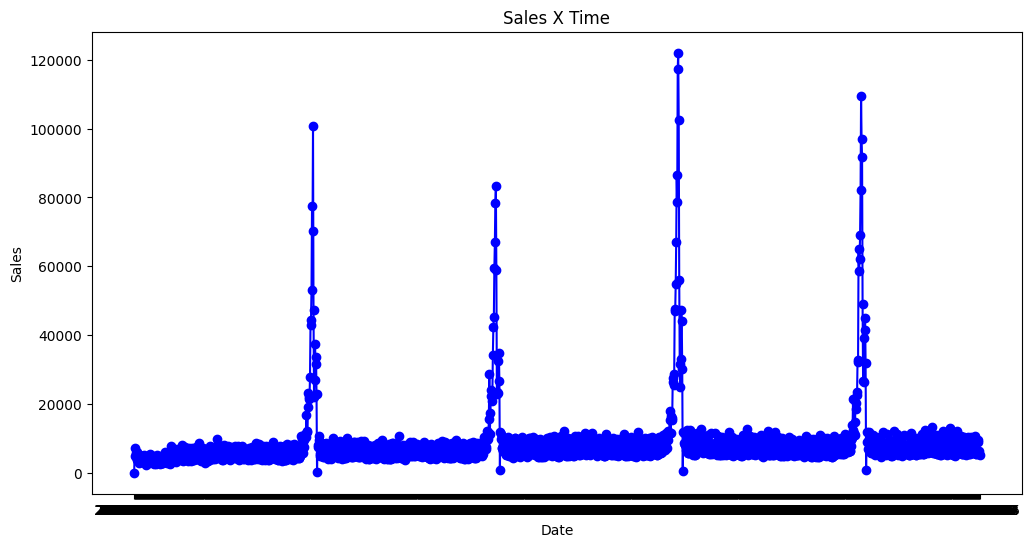

In [ ]:
# FROZEN FOOD TIME SERIES
plt.figure(figsize=(12, 6))
plt.plot(df_agg_FF['date'], df_agg_FF['sales'], marker='o', linestyle='-', color='b')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales X Time')

# Mostrar o gráfico
plt.show()

**Handling of Missing Data**:

For entries with missing values, the corresponding rows were filled with information from the immediately preceding entry. This was done considering the continuity of temporal data and to avoid the loss of relevant information for the model.



In [ ]:
# Calculate the count of null values for each column
null_counts = df_agg_FF.isnull().sum()

# Display the null counts
print(null_counts)

date      0
family    0
sales     0
dtype: int64


In [ ]:
# Calculate the maximum and minimum dates
max_date = df_agg_FF['date'].max()
min_date = df_agg_FF['date'].min()

# Print the maximum and minimum dates
print("Data máxima:", max_date)
print("Data mínima:", min_date)

Data máxima: 2017-08-15
Data mínima: 2013-01-01


In [ ]:
#making sure we have all data sequence
#dRan = pd.date_range(start ='2013-01-01', end ='2017-08-15')
dRan = pd.date_range(start =min_date, end = max_date)
date_list = dRan.tolist()
dRan = pd.DataFrame({'date': date_list})

df_agg_FF['date'] = pd.to_datetime(df_agg_FF['date'])

In [ ]:
df_agg_FF = dRan.merge(df_agg_FF, how='left', on='date')

#filling nulls, with previous date
df_agg_FF.fillna(method='ffill', inplace=True)

In [ ]:
df_agg_FF.drop('family', axis=1, inplace=True)

In [ ]:
df_agg_FF.head()

,date,sales
0,2013-01-01,29.654999
1,2013-01-02,7115.388000
2,2013-01-03,4760.805009
3,2013-01-04,4525.934004
4,2013-01-05,5781.605010


In [ ]:
#dropping first line because amount seems incomplete
df_agg_FF.drop(df_agg_FF.index[0], inplace=True)

###Feature Engineering

**Temporal Feature Extraction**:

* `Month of the Year`: A new feature was created to represent the month of the year in which the transactions occurred. This was done to capture seasonal variations in sales, such as sales peaks during festive or seasonal periods.

* `Day of the Month`: Dates were processed to restrict each entry to represent only the corresponding day of the month. This allowed for a more granular view of sales and helped identify specific patterns within each month.




In [ ]:
df_agg_FF['month'] = df_agg_FF['date'].dt.month
df_agg_FF['day_of_year'] = df_agg_FF['date'].dt.dayofyear

## Train and Test Split

In [ ]:
train_start = '2013-01-01'
train_end = '2016-06-30'
test_start = '2016-07-01'
test_end = '2017-08-15'

In [ ]:
df_train = df_agg_FF[(df_agg_FF['date'] >= train_start) & (df_agg_FF['date'] <= train_end)]
df_test = df_agg_FF[(df_agg_FF['date'] >= test_start) & (df_agg_FF['date'] <= test_end)]

In [ ]:
df_train.head()

,date,sales,month,day_of_year
1,2013-01-02,7115.388000,1,2
2,2013-01-03,4760.805009,1,3
3,2013-01-04,4525.934004,1,4
4,2013-01-05,5781.605010,1,5
5,2013-01-06,6114.882010,1,6


In [ ]:
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)

### Scaling

**Data Normalization**:

The features were normalized using the Min-Max scaler to ensure that all variables had a comparable scale, which is crucial for training machine learning models and to prevent bias towards features with larger magnitudes, making gradient descent converge faster. The Min-Max scaler transforms the data to a specific range, typically between -1 and 1, ensuring that the features are on a similar scale. This normalization process is essential for the proper functioning of the models, as it helps in avoiding numerical instability and facilitating the convergence of optimization algorithms.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_train_sc = scaler.fit_transform(df_train)
df_test_sc = scaler.fit_transform(df_test)

In [ ]:
df_train_sc

array([[-0.88721899, -1.        , -0.99450549],
       [-0.92588348, -1.        , -0.98901099],
       [-0.92974028, -1.        , -0.98351648],
       ...,
       [-0.91982186, -0.09090909, -0.01648352],
       [-0.91201597, -0.09090909, -0.01098901],
       [-0.91853903, -0.09090909, -0.00549451]])

### "Windowning"

In LSTM (Long Short-Term Memory) models, the concept of the window size refers to the number of time steps or sequence length that the model considers as input at any given point during training or prediction. The window size essentially determines how far back in the sequence the model can look to make a prediction.

Look at the example below: if I choose a window = 3, this means that I will use the values 3, 1, and 4 to predict the value 2. The values of 1, 4, and 2 to predict -1, and so on.

<p align=center>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdw7RM2%2Fbtq74pzBE4V%2FqDuPXAcH6unAPd789THFs0%2Fimg.png" width="60%"></p>


To choose the window size, it depends on multiple factors, including the model type and the behavior of the signal considered for experimentation.

To simplify the model, in addition to the window of the last 30 days' sales, we utilized the aforementioned temporal information.

This approach was adopted to maintain a balance between the inclusion of relevant temporal patterns and the reduction of unnecessary complexities, allowing for a streamlined and effective analysis of the data.

 The dimensions below represent the number of training and testing samples, the window size (or number of previous time steps), and the number of features considered at each time step for the training and testing datasets, and it is these matrices that we will use to feed our neural networks.

In [ ]:
X_train, y_train = df_windowning(df_train_sc,30)
X_test, y_test = df_windowning(df_test_sc,30)

X_train.shape, y_train.shape, X_test.shape, y_test.shape
# ((number of inputs, window size, number os features))

((1246, 30, 3), (1246,), (381, 30, 3), (381,))

## Model 1 :

###RNN
The first model addressed is the Recurrent Neural Networks (RNN). This type of model is well suited to capture sequential dependencies in time-based data and has been widely used in time series forecasting. We will explore the features and limitations of this specific model in relation to forecasting time series data.

RNNs are particularly effective in capturing temporal dependencies due to their ability to retain a memory of previous inputs. This characteristic makes them well-adapted for tasks where historical context is crucial for predicting future outcomes. However, one of the limitations of traditional RNNs is their struggle to capture long-term dependencies effectively, often leading to issues such as vanishing or exploding gradients.

In the context of time series forecasting, RNNs can provide valuable insights into seasonal patterns, trends, and other temporal relationships within the data. By incorporating the temporal features, such as the month and day of the year, RNNs can potentially enhance their predictive capabilities, allowing for more accurate and nuanced forecasts. Nonetheless, the performance of RNNs heavily depends on the availability of sufficient data and the proper tuning of hyperparameters to avoid overfitting or underfitting.

In [ ]:
model_1 =  Sequential([
    SimpleRNN(32, input_shape=X_train.shape[1:]),
    Dense(1)
])
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.005), metrics=[MeanAbsolutePercentageError()])

In [ ]:
history_model_1 = model_1.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
20/20 [==============================] - 2s 27ms/step - loss: 0.2135 - mean_absolute_percentage_error: 39.2633 - val_loss: 0.0401 - val_mean_absolute_percentage_error: 25.0016
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0173 - mean_absolute_percentage_error: 14.8695 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 14.7025
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0096 - mean_absolute_percentage_error: 10.7742 - val_loss: 0.0133 - val_mean_absolute_percentage_error: 12.1599
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0084 - mean_absolute_percentage_error: 9.5922 - val_loss: 0.0120 - val_mean_absolute_percentage_error: 11.6821
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0078 - mean_absolute_percentage_error: 9.4497 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 11.2897
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - los

12/12 [==============================] - 0s 3ms/step


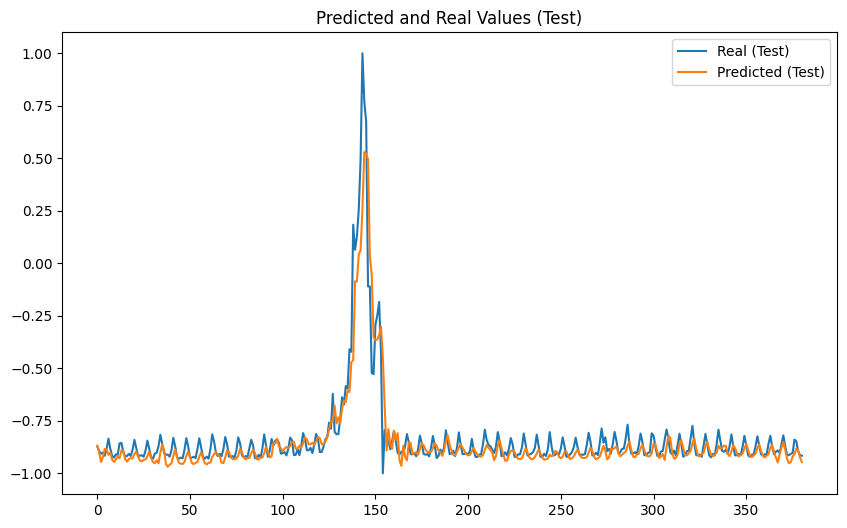

In [ ]:
plot_real_predict(model_1, X_test, y_test)


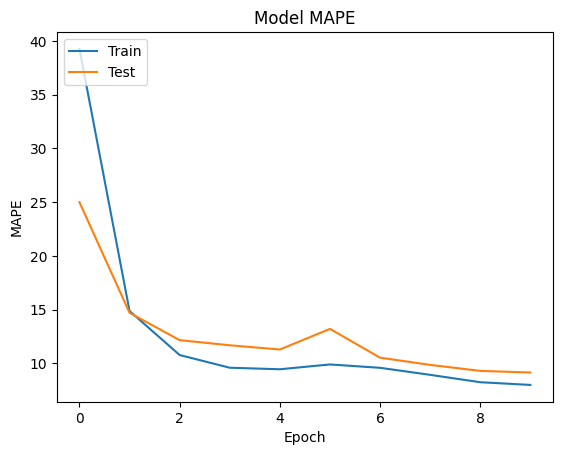

In [ ]:
plot_mape(history_model_1)

## Model 2 :

###LSTM
The second model analyzed is the Long Short-Term Memory (LSTM), an advanced variant of RNN. The LSTM architecture was designed to overcome the limitations of traditional RNNs in capturing long-term dependencies in sequential data. We will investigate how the LSTM model handles time series datasets and the improvements it offers compared to the RNN model.

LSTMs are specifically engineered to mitigate the vanishing gradient problem that often occurs in traditional RNNs, enabling them to capture long-term dependencies more effectively. This is achieved through the use of specialized memory cells that can retain information over extended sequences, making LSTMs well-suited for modeling complex temporal dynamics within data.

In the context of time series forecasting, LSTM models exhibit a superior capability to capture intricate patterns and dependencies, allowing for more accurate predictions even over extended time horizons. By leveraging their unique memory cell structure, LSTMs can effectively remember and utilize information from earlier time steps, making them highly suitable for tasks that require the analysis of long sequences of temporal data.

Despite their robust performance, LSTMs can be computationally intensive and may require careful tuning of hyperparameters to prevent overfitting, particularly when dealing with large datasets. Additionally, the complex architecture of LSTMs may demand a more extensive computational infrastructure compared to traditional RNNs, which should be considered when evaluating their feasibility for deployment in real-world applications.

In [ ]:
model_2 = Sequential([
    LSTM(32, input_shape=X_train.shape[1:]),
    Dense(1)
])
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsolutePercentageError()])

In [ ]:
history_model_2 = model_2.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
20/20 [==============================] - 4s 78ms/step - loss: 0.2737 - mean_absolute_percentage_error: 53.1156 - val_loss: 0.0348 - val_mean_absolute_percentage_error: 20.2960
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.0284 - mean_absolute_percentage_error: 22.0868 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 16.3266
Epoch 3/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0178 - mean_absolute_percentage_error: 14.9980 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 14.6363
Epoch 4/10
20/20 [==============================] - 1s 48ms/step - loss: 0.0149 - mean_absolute_percentage_error: 13.2805 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 13.9480
Epoch 5/10
20/20 [==============================] - 1s 51ms/step - loss: 0.0141 - mean_absolute_percentage_error: 12.6298 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 13.5224
Epoch 6/10
20/20 [==============================] - 1s 27ms/step 

12/12 [==============================] - 1s 8ms/step


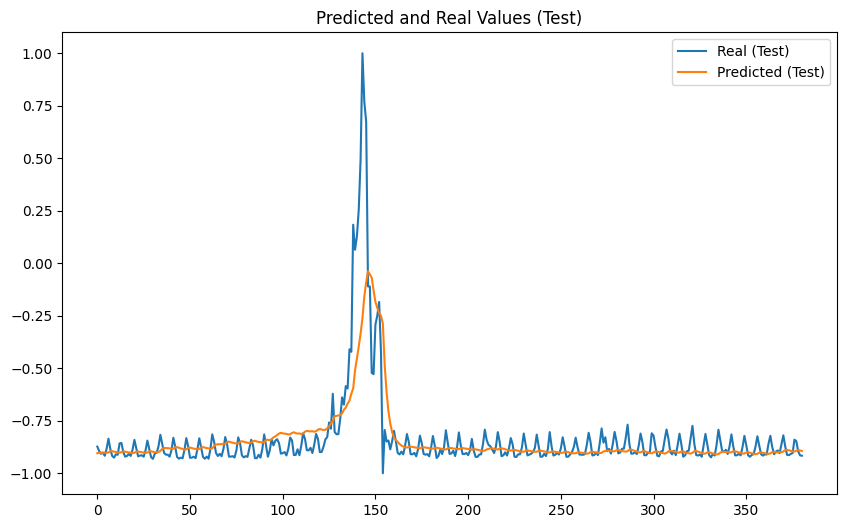

In [ ]:
plot_real_predict(model_2, X_test, y_test)

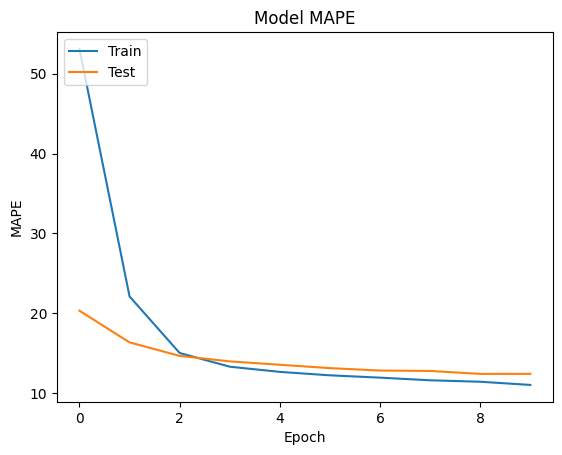

In [ ]:
plot_mape(history_model_2)

## Model 3:

###LSTM-CNN
Moreover, we will explore the combination of LSTM with Convolutional Neural Networks (LSTM-CNN). This hybrid approach aims to capture long-term dependencies in sequential and spatial data, leveraging the capabilities of both architectures. We will assess how this combination improves predictions compared to individual LSTM and RNN models.

By integrating LSTM and CNN architectures, the LSTM-CNN model captures complex patterns in both temporal and spatial data. The CNN's convolutional layers extract spatial features, while the LSTM retains the ability to capture long-term temporal dependencies. This approach is useful for tasks involving complex spatiotemporal data analysis, such as video analysis or multivariate time series forecasting.

The integration of CNNs with LSTMs extracts spatial patterns in sequential data, improving the understanding of underlying relationships. This synergy can significantly enhance the model's predictive performance, particularly with datasets exhibiting both temporal and spatial correlations.

However, the LSTM-CNN model's complexity requires careful parameter tuning and computational resources. Maintaining the optimal balance between the architectures is crucial to harness the hybrid model's potential while avoiding overfitting or underfitting. Additionally, interpreting the combined model may require additional analysis to understand each component's contributions to the final predictions.

In [ ]:
model_3 = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    LSTM(32),
    Dense(1)
])
model_3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsolutePercentageError()])

In [ ]:
history_model_3 = model_3.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
20/20 [==============================] - 5s 114ms/step - loss: 0.0718 - mean_absolute_percentage_error: 27.7282 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 17.8769
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0174 - mean_absolute_percentage_error: 14.9581 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 13.4575
Epoch 3/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0111 - mean_absolute_percentage_error: 10.5377 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 11.5531
Epoch 4/10
20/20 [==============================] - 1s 27ms/step - loss: 0.0095 - mean_absolute_percentage_error: 9.4899 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 10.6822
Epoch 5/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0082 - mean_absolute_percentage_error: 8.5671 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 10.3177
Epoch 6/10
20/20 [==============================] - 1s 31ms/step -

12/12 [==============================] - 1s 5ms/step


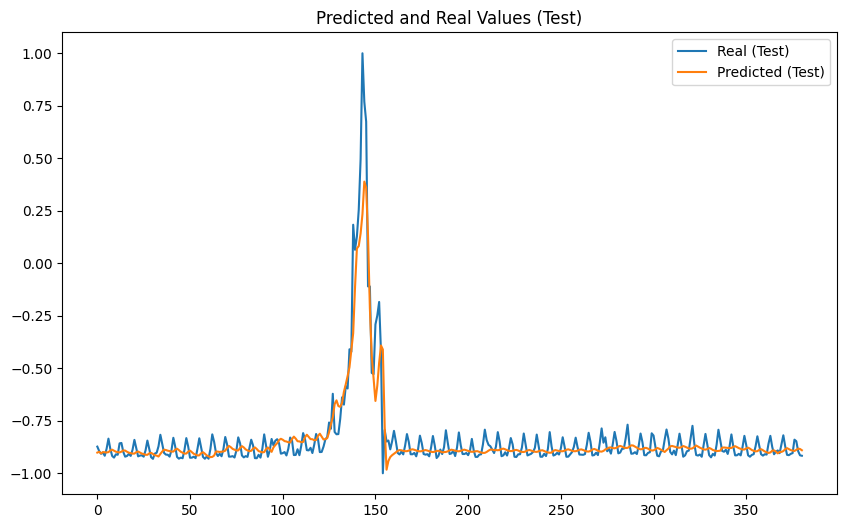

In [ ]:
plot_real_predict(model_3,X_test, y_test)

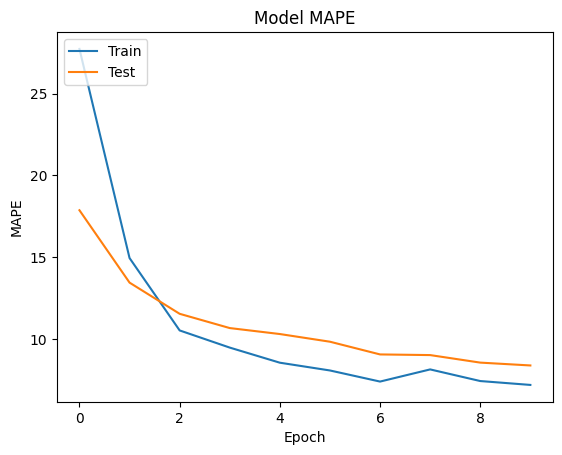

In [ ]:
plot_mape(history_model_3)

#Conclusions

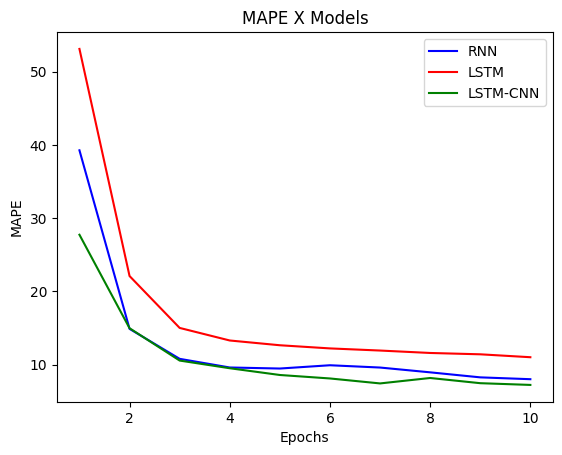

In [ ]:
mape_model_v1 = history_model_1.history['mean_absolute_percentage_error']
mape_model_v2 = history_model_2.history['mean_absolute_percentage_error']
mape_model_v3 = history_model_3.history['mean_absolute_percentage_error']


epochs = range(1, len(mape_model_v1) + 1)


plt.plot(epochs, mape_model_v1, 'b', label='RNN')
plt.plot(epochs, mape_model_v2, 'r', label='LSTM')
plt.plot(epochs, mape_model_v3, 'g', label='LSTM-CNN')
plt.title('MAPE X Models')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()


In the analyses presented, we observed that a simpler RNN model performed similarly to our network with the convolutional layer. This finding suggests that we can consider the following insights for future analyses:

* `Simplicity versus Complexity`: The fact that the simpler RNN model achieved results similar to the more complex model with a convolutional layer may indicate that the task at hand may not require the additional complexity provided by the convolutional layer.

* `Nature, Size, and Diversity of the Data`: Our dataset is relatively small in terms of the number of inputs, and we analyzed a combination of a few features. The more complex models may not have had the opportunity to showcase their full potential, but increasing the dataset size and incorporating a diverse range of features could help better assess their capabilities and potentially address issues related to overfitting.

To add value to more complex analyses, we could consider using a larger number of data inputs, incorporating a greater number of features, performing feature engineering, and employing feature selection algorithms.

Additionally, we can experiment with more complex networks, incorporating a greater number of layers and neurons, as well as increasing the number of epochs and fine-tuning other necessary hyperparameters in the assessment of a more complex model.

These enhancements can provide deeper insights and a more comprehensive understanding of the data, potentially leading to improved model performance and more accurate predictions in future analyses, while also keeping a vigilant eye on mitigating any instances of overfitting.